In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Column, Integer, Float, String, Date, func
from sqlalchemy.orm import sessionmaker


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\gmyou\AppData\Local\Temp\ipykernel_276\3555078317.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement
# the station class to a variable called `Station`
Station = Base.classes.station

In [8]:
# Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

class Measurement(Base):
    __tablename__ = 'measurement'
    id = Column(Integer, primary_key=True)
    station = Column(String)
    date = Column(Date)
    prcp = Column(Float)  # Precipitation data
    tobs = Column(Integer)  # Temperature observations
    __table_args__ = {'extend_existing': True}  
    
# Step 3: Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Step 4: Query for the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
print("Most Recent Date:", most_recent_date)

# Don't forget to close the session when done
session.close()

Most Recent Date: 2017-08-23


In [10]:
# Check all columns mapped for the Measurement table
print(Measurement.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']


Date One Year Ago: 2016-08-23
[(datetime.date(2016, 8, 23), 0.0), (datetime.date(2016, 8, 23), 0.15), (datetime.date(2016, 8, 23), 0.05), (datetime.date(2016, 8, 23), None), (datetime.date(2016, 8, 23), 0.02)]
        date  prcp
0 2016-08-23  0.00
1 2016-08-23  0.15
2 2016-08-23  0.05
3 2016-08-23   NaN
4 2016-08-23  0.02


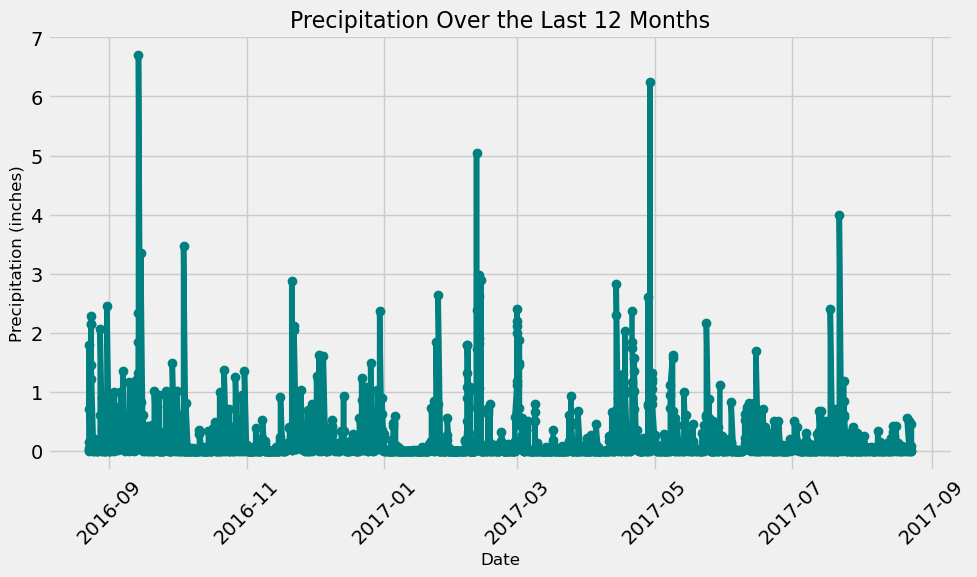

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
from datetime import timedelta


most_recent_date = session.query(func.max(Measurement.date)).scalar()
year_ago_date = most_recent_date - timedelta(days=365)
print(f"Date One Year Ago: {year_ago_date}")


# Perform a query to retrieve the data and precipitation scores

# Query precipitation data for the last 12 months
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= year_ago_date)
    .order_by(Measurement.date)
    .all()
)

# Print the first few rows of data
print(precipitation_data[:5])

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "prcp"])

# Sort the dataframe by date
# Convert the 'date' column to datetime
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])

# Print the first few rows of the DataFrame
print(precipitation_df.head()) 



# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df["date"], precipitation_df["prcp"], marker='o', linestyle='-', color='teal')
plt.title("Precipitation Over the Last 12 Months", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (inches)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [ ]:
# Close Session
session.close()
